In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# !pip install ControlBurn==0.0.9
from ControlBurn.ControlBurn import ControlBurnClassifier


# Load wine dataset

In [7]:
wine_train_df = pd.read_csv("datasets/benchmark/wine_train.csv")
wine_train_df["quality"] = wine_train_df["quality"].astype(int)
wine_train_df.to_csv("datasets/benchmark/wine_train.csv", index=False)

wine_train_df = pd.read_csv("datasets/benchmark/wine_train.csv")

X_wine_train = wine_train_df.loc[:, wine_train_df.columns != "quality"]
Y_wine_train = wine_train_df["quality"]

wine_test_df = pd.read_csv("datasets/benchmark/wine_test.csv")
X_wine_test = wine_test_df.loc[:, wine_test_df.columns != "quality"]
Y_wine_test = wine_test_df["quality"]

# Helper Functions

In [80]:
def square_loss(y_true, y_pred):
    n = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / n

def rank_feature_importance(feature_name, feature_score):
    n = len(feature_name)
    lst = [(feature_name[i], feature_score[i]) for i in range(n)]
    lst.sort(key=lambda x:x[1], reverse=True)
    # uncomment to see just the rank without the score
    # return [x[0] for x in lst]
    return lst

def select_features_filter(all_features, target_features):
    lst = []
    for i in range(len(all_features)):
        if all_features[i] in target_features:
            lst.append(True)
        else:
            lst.append(False)
    return lst

def gen_graph(X_train, X_test, all_features, ranked_features, min_features, max_features, Y_train, Y_test, dataset_name, is_LASSO):
    # when is_LASSO = true
    # ranked_features = [[feature set 1], [feature set 2], ...]

    # when is_LASSO = false
    # ranked_features = [ f1, f2, f3, ...] ranked by importance
    if is_LASSO:
        n = len(ranked_features)
    else:
        n = max_features + 1 - min_features
    num_estimators = 100
    rf_acc_lst = []
    rf_f1_lst = []

    ridge_acc_lst = []
    ridge_f1_lst = []

    # generate RF baseline
    rf_clf = RandomForestClassifier(random_state=1, n_estimators=num_estimators)
    rf_clf.fit(X_train, Y_train)
    rf_Y_pred = rf_clf.predict(X_test)
    rf_acc_baseline = accuracy_score(Y_test, rf_Y_pred)
    rf_acc_baseline_arr = np.ones(n) * rf_acc_baseline
    rf_f1_baseline = f1_score(Y_test, rf_Y_pred)
    rf_f1_baseline_arr = np.ones(n) * rf_f1_baseline

    # generate Ridge baseline
    ridge_clf = RidgeClassifier()
    ridge_clf.fit(X_train, Y_train)
    ridge_Y_pred = ridge_clf.predict(X_test)
    ridge_acc_baseline = accuracy_score(Y_test, ridge_Y_pred)
    ridge_acc_baseline_arr = np.ones(n) * ridge_acc_baseline
    ridge_f1_baseline = f1_score(Y_test, ridge_Y_pred)
    ridge_f1_baseline_arr = np.ones(n) * ridge_f1_baseline
    
    n = max_features + 1 - min_features

    if is_LASSO:
        loop_elements = ranked_features
    else:
        loop_elements = np.arange(min_features, max_features + 1)


    for e in loop_elements:
        if is_LASSO:
            target_features = e
        else:
            target_features = ranked_features[:e]
        features_filter = select_features_filter(all_features, target_features)
        selected_X_train = X_train.loc[:, features_filter]
        selected_X_test = X_test.loc[:, features_filter]
        
        # random forest
        rf_clf = RandomForestClassifier(random_state=1, n_estimators=num_estimators)
        rf_clf.fit(selected_X_train, Y_train)
        rf_Y_pred = rf_clf.predict(selected_X_test)

        rf_acc = accuracy_score(Y_test, rf_Y_pred)
        rf_f1 = f1_score(Y_test, rf_Y_pred)
        rf_acc_lst.append(rf_acc)
        rf_f1_lst.append(rf_f1)

        # ridge
        ridge_clf = RidgeClassifier()
        ridge_clf.fit(selected_X_train, Y_train)
        ridge_Y_pred = ridge_clf.predict(selected_X_test)

        ridge_acc = accuracy_score(Y_test, ridge_Y_pred)
        ridge_f1 = f1_score(Y_test, ridge_Y_pred)
        ridge_acc_lst.append(ridge_acc)
        ridge_f1_lst.append(ridge_f1)
    
    if is_LASSO:
        x_axis = [len(x) for x in ranked_features]
    else:
        x_axis = np.arange(min_features, max_features + 1)
    fig, ax = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)

    ax[0].plot(x_axis, ridge_acc_baseline_arr, '-o', label='ridge all features')
    ax[0].plot(x_axis, rf_acc_baseline_arr, '-o', label='random forest all features')
    ax[0].plot(x_axis, ridge_acc_lst, '-o', label='ridge with selected features')
    ax[0].plot(x_axis, rf_acc_lst, '-o', label='random forest with selected features')
    ax[0].set(xlabel='number of selected features by importance', ylabel='accuracy', title=f'{dataset_name} Dataset: Accuracy vs Number of Selected Features')
    ax[0].legend()

    ax[1].plot(x_axis, ridge_f1_baseline_arr, '-o', label='ridge all features')
    ax[1].plot(x_axis, rf_f1_baseline_arr, '-o', label='random forest all features')
    ax[1].plot(x_axis, ridge_f1_lst, '-o', label='ridge with selected features')
    ax[1].plot(x_axis, rf_f1_lst,  '-o', label='random forest with selected features')
    ax[1].set(xlabel='number of selected features by importance', ylabel='f1 score', title=f'{dataset_name} Dataset: F1 Score vs Number of Selected Features')
    ax[1].legend()

    plt.show()

def select_feature(all_features, feature_filter):
    lst = []
    for i in range(len(feature_filter)):
        if feature_filter[i]:
            lst.append(all_features[i])
    return lst



# Random Forest Feature Selection

In [99]:
def RF_Selection(X_train, Y_train, X_test, Y_test, dataset_name):
    n_estimators = 1000
    rf_clf = RandomForestClassifier(random_state=1, n_estimators=n_estimators)
    rf_clf.fit(X_train, Y_train)
    rf_ranked_importance = rank_feature_importance(X_train.columns, rf_clf.feature_importances_)
    print(rf_ranked_importance)

    all_features = list(X_train.columns)
    rf_ranked_features = [ x[0] for x in rf_ranked_importance]
    min_features = 1
    max_features = len(rf_ranked_features)
    gen_graph(X_train, X_test, all_features, rf_ranked_features, min_features, max_features, Y_train, Y_test, dataset_name, False)

    

[('alcohol', 0.1900878050222841), ('sulphates', 0.12329367115056622), ('volatile acidity', 0.1074590805268899), ('total sulfur dioxide', 0.09647338548417515), ('density', 0.09572292341266321), ('chlorides', 0.07726932610186427), ('fixed acidity', 0.06582999148639491), ('pH', 0.06555439969572335), ('citric acid', 0.06271611022155546), ('free sulfur dioxide', 0.06043160975741127), ('residual sugar', 0.05516169714047216)]


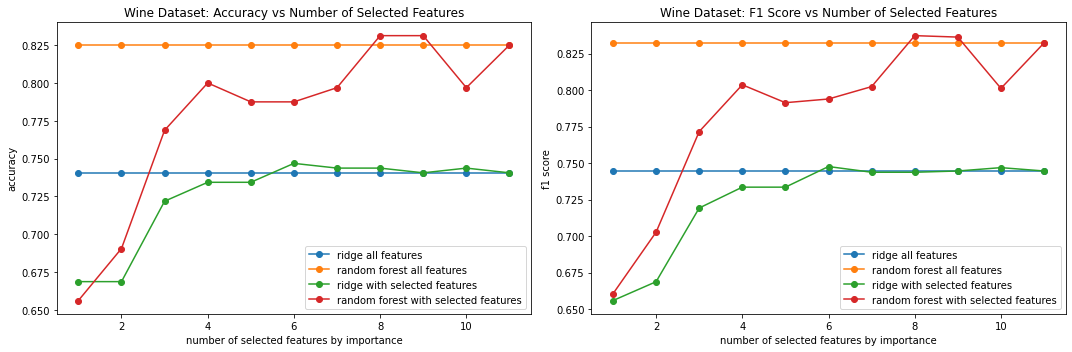

In [100]:
RF_Selection(X_wine_train, Y_wine_train, X_wine_test, Y_wine_test, "Wine")

# Control Burn Feature Selection

In [101]:
def CB_Selection(X_train, Y_train, X_test, Y_test, dataset_name, alpha):
    cb = ControlBurnClassifier(alpha = alpha, solver = 'SCS')
    cb.fit(X_train, Y_train)
    cb_ranked_importance = rank_feature_importance(cb.features_selected_, cb.feature_importances_)

    print(cb_ranked_importance)
    print("number of trees = ", len(cb.forest))

    all_features = list(X_train.columns)
    cb_ranked_features = [ x[0] for x in cb_ranked_importance]
    min_features = 1
    max_features = len(cb_ranked_features)
    gen_graph(X_train, X_test, all_features, cb_ranked_features, min_features, max_features, Y_train, Y_test, dataset_name, False)

[('volatile acidity', 1.5989357482642823), ('total sulfur dioxide', 0.6277349786254784), ('fixed acidity', 0.19453712792296646), ('free sulfur dioxide', 0.10217224268374345), ('chlorides', 0.1015614627109925), ('residual sugar', 0.09054774931570422), ('citric acid', 0.05664788232751472), ('sulphates', 0.0), ('alcohol', 0.0)]
number of trees =  43


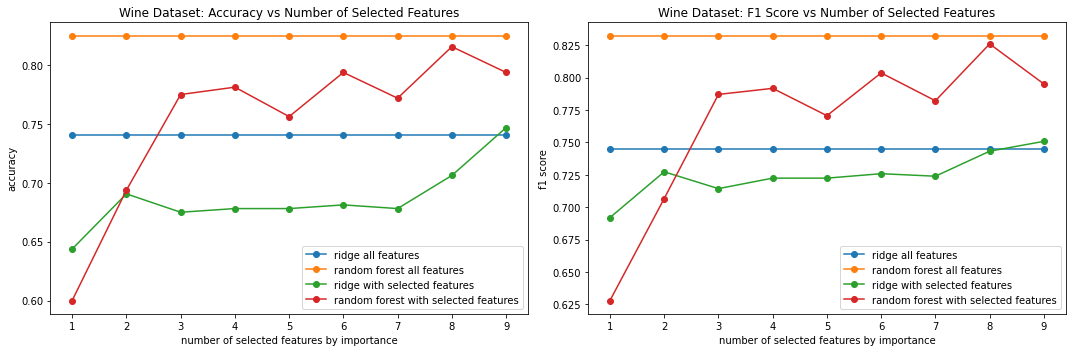

In [102]:
CB_Selection(X_wine_train, Y_wine_train, X_wine_test, Y_wine_test, "Wine", 0.001)

# LASSO Feature Selection

In [108]:
def lasso_select_feature(alphas, X_train, Y_train):
    features_used = []
    selected_feature_set = []
    for a in alphas:
        lasso_clf = linear_model.Lasso(alpha=a, normalize=True, random_state=1)
        lasso_clf.fit(X_train, Y_train)
        feature_filter = ~np.isclose(lasso_clf.coef_, 0)
        selected_features = select_feature(X_train.columns, feature_filter)
        if len(selected_features) > 0 and not selected_features in selected_feature_set:
            print(selected_features)
            selected_feature_set.append(selected_features)
        features_used.append(np.sum(feature_filter))
    
    plt.plot(alphas, features_used)
    plt.xlabel('alpha (L1 constant)')
    plt.ylabel('selected features')
    plt.title("LASSO feature selection")
    plt.legend()
    plt.show()
    
    return selected_feature_set

def LASSO_Selection(X_train, Y_train, X_test, Y_test, dataset_name, alphas_space):
    lasso_feature_set = lasso_select_feature(alphas_space, X_train, Y_train)
    print(lasso_feature_set)
    all_features = list(X_train.columns)
    min_features = 1
    max_features = len(all_features)
    gen_graph(X_train, X_test, all_features, lasso_feature_set, min_features, max_features, Y_train, Y_test, dataset_name, True)
    


No handles with labels found to put in legend.


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'alcohol']
['alcohol']


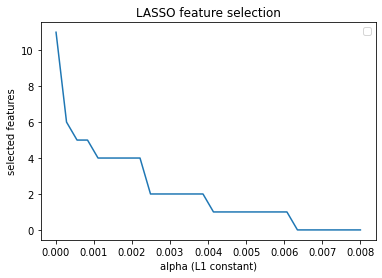

[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'], ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol'], ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol'], ['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol'], ['volatile acidity', 'alcohol'], ['alcohol']]


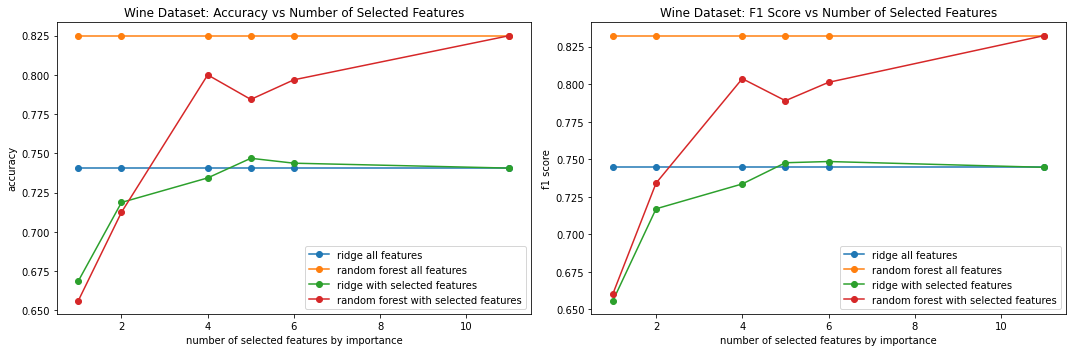

In [109]:
LASSO_Selection(X_wine_train, Y_wine_train, X_wine_test, Y_wine_test, "Wine", np.linspace(0.00001,0.008,30))